In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 函数式 API

#INFO:关注多输入多输出训练方式，以及embedding层。注意keras如何设置共享embedding

In [2]:
### 2.2.1 简介
##Keras 函数式 API 是一种比 tf.keras.Sequential API 更加灵活的模型创建方式。
#函数式 API 可以处理具有非线性拓扑的模型、具有共享层的模型，以及具有多个输入或输出的模型。

#深度学习模型通常是层的有向无环图 (DAG)。因此，函数式 API 是构建层计算图的一种方式。

## 一个具有三层的基本计算图。要使用函数式 API 构建此模型，请先创建一个输入节点：
inputs = keras.Input(shape=(784,))

In [3]:
#返回的 inputs 包含馈送给模型的输入数据的形状和 dtype。形状如下：
inputs.shape

TensorShape([None, 784])

In [4]:
#dtype 如下：
inputs.dtype

tf.float32

In [5]:
#可以通过在此 inputs 对象上调用层，在层计算图中创建新的节点：
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

In [7]:
#“层调用”操作就像从“输入”向您创建的该层绘制一个箭头。您将输入“传递”到 dense 层，然后得到 x。
#让我们为层计算图多添加几个层：
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

In [8]:
#定义模型
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


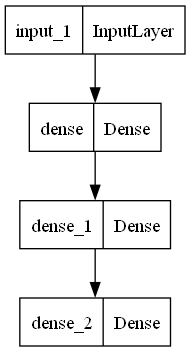

In [9]:
#您还可以将模型绘制为计算图：
keras.utils.plot_model(model, "my_first_model.png")

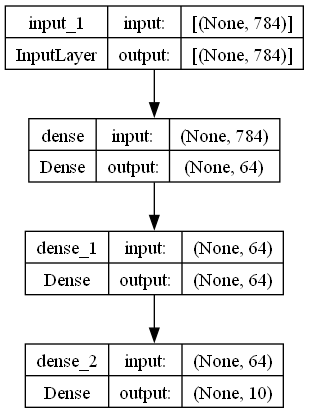

In [10]:
#并且，您还可以选择在绘制的计算图中显示每层的输入和输出形状：
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [11]:
#此图和代码几乎完全相同。在代码版本中，连接箭头由调用操作代替。
#“层计算图”是深度学习模型的直观心理图像，而函数式 API 是创建密切反映此图像的模型的方法。

In [ ]:
### 2.2.2 训练，评估和推断  - 网络故障，未运行
# 对于使用函数式 API 构建的模型来说，其训练、评估和推断的工作方式与 Sequential 模型完全相同。
#如下所示，加载 MNIST 图像数据，将其改造为向量，将模型与数据拟合（同时监视验证拆分的性能），然后在测试数据上评估模型：
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [ ]:
### 2.2.3 保存和序列化 - 网络故障，未运行
#对于使用函数式 API 构建的模型，其保存模型和序列化的工作方式与 Sequential 模型相同。
#保存函数式模型的标准方式是调用 model.save() 将整个模型保存为单个文件。

##保存的文件包括：
#   模型架构
#   模型权重值（在训练过程中得知）
#   模型训练配置（如果有的话，如传递给 compile）
#   优化器及其状态（如果有的话，用来从上次中断的地方重新开始训练）

model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

In [14]:
### 2.2.4 处理复杂的计算图拓扑 - 非常重要
#具有多个输入和输出的模型
#函数式 API 使处理多个输入和输出变得容易。而这无法使用 Sequential API 处理。

#例如，如果您要构建一个系统，该系统按照优先级对自定义问题工单进行排序，
#然后将工单传送到正确的部门，则此模型将具有三个输入：
#   工单标题（文本输入），
#   工单的文本正文（文本输入），以及
#   用户添加的任何标签（分类输入）

#此模型将具有两个输出：
#   介于 0 和 1 之间的优先级分数（标量 Sigmoid 输出），以及
#   应该处理工单的部门（部门范围内的 Softmax 输出）。

#您可以使用函数式 API 通过几行代码构建此模型：
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

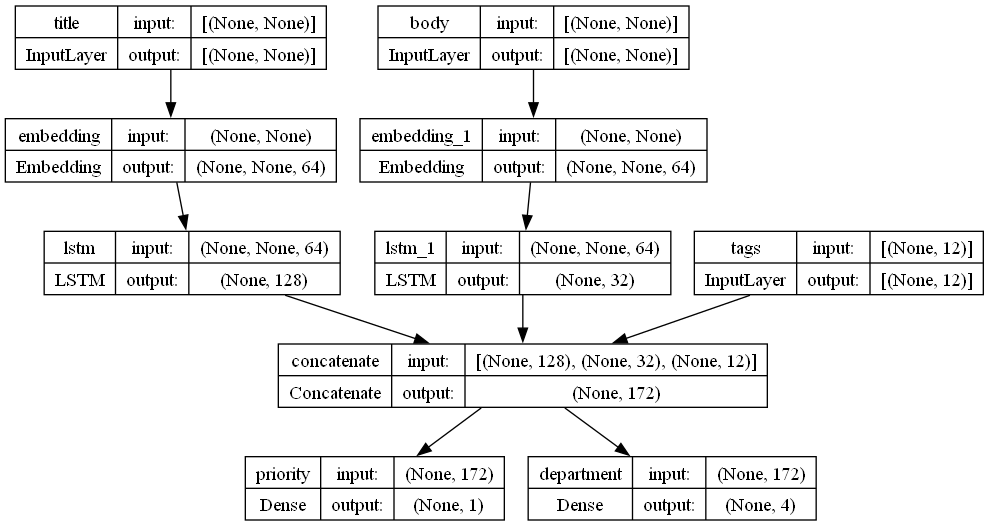

In [16]:
#现在绘制模型：
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [17]:
#编译此模型时，可以为每个输出分配不同的损失。甚至可以为每个损失分配不同的权重，以调整其对总训练损失的贡献。
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

In [18]:
#由于输出层具有不同的名称，您还可以使用对应的层名称指定损失和损失权重：
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

In [19]:
#通过传递输入和目标的 NumPy 数组列表来训练模型：
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2


40/40 [==============================] - 5s 28ms/step - loss: 1.2832 - priority_loss: 0.7037 - department_loss: 2.8972
Epoch 2/2
40/40 [==============================] - 1s 27ms/step - loss: 1.2934 - priority_loss: 0.6983 - department_loss: 2.9757


In [ ]:
#当使用 Dataset 对象调用拟合时，它应该会生成一个列表元组（如 ([title_data, body_data, tags_data], [priority_targets, dept_targets]) 
#或一个字典元组（如 ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})）。

In [20]:
## 2.小 ResNet 模型
#除了具有多个输入和输出的模型外，函数式 API 还使处理非线性连接拓扑（这些模型的层没有按顺序连接）变得容易。这是 Sequential API 无法处理的。
#关于这一点的一个常见用例是残差连接。让我们来为 CIFAR10 构建一个小 ResNet 模型以进行演示：
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 30, 30, 32)           896       ['img[0][0]']                 
                                                                                                  
 conv2d_5 (Conv2D)           (None, 28, 28, 64)           18496     ['conv2d_4[0][0]']            
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 64)             0         ['conv2d_5[0][0]']            
 g2D)                                                                                    

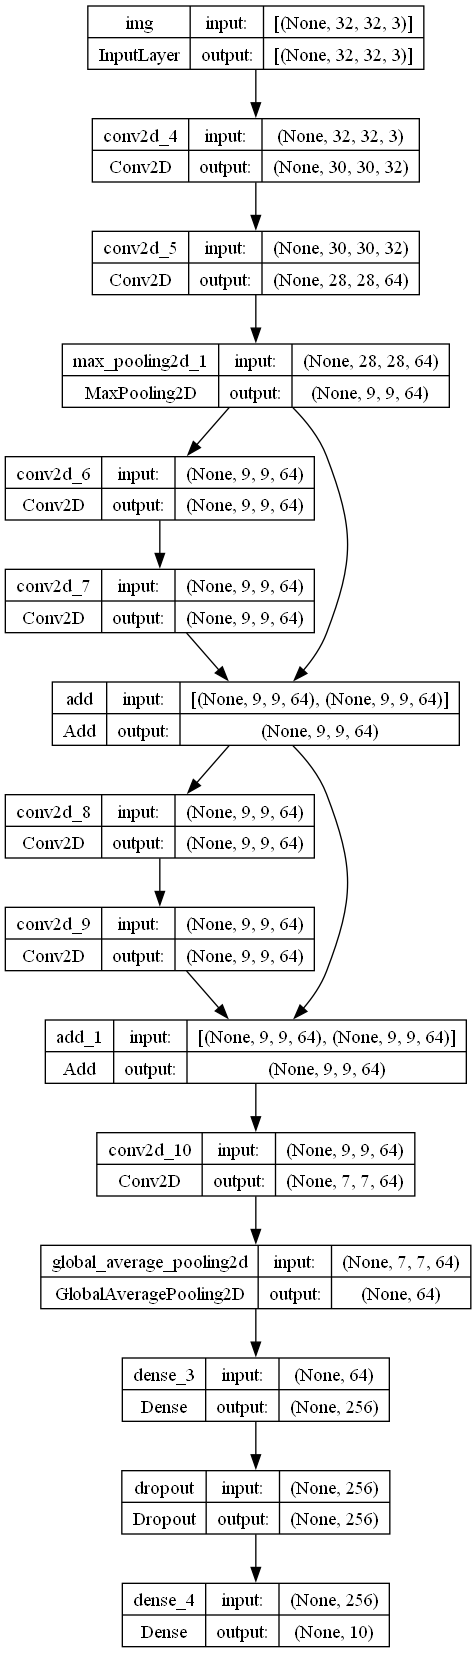

In [21]:
#绘制模型：
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [22]:
#现在训练模型：
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 2s 105ms/step - loss: 2.3080 - acc: 0.0950 - val_loss: 2.3083 - val_acc: 0.1000


In [23]:
### 2.2.5 共享层 - 非常重要
#函数式 API 的另一个很好的用途是使用shared layers的模型。共享层是在同一个模型中多次重用的层实例，
#它们会学习与层计算图中的多个路径相对应的特征。

#共享层通常用于对来自相似空间（例如，两个具有相似词汇的不同文本）的输入进行编码。它们可以实现在这些不同的输入之间共享信息，
#以及在更少的数据上训练这种模型。如果在其中的一个输入中看到了一个给定单词，那么将有利于处理通过共享层的所有输入。

#要在函数式 API 中共享层，请多次调用同一个层实例。例如，下面是一个在两个不同文本输入之间共享的 Embedding 层：

# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

In [ ]:
### 2.2.6 提取和重用层计算图中的节点 - 网络故障，未运行
#由于要处理的层计算图是静态数据结构，可以对其进行访问和检查。而这就是将函数式模型绘制为图像的方式。
#这也意味着您可以访问中间层的激活函数（计算图中的“节点”）并在其他地方重用它们，这对于特征提取之类的操作十分有用。
#让我们来看一个例子。下面是一个 VGG19 模型，其权重已在 ImageNet 上进行了预训练：
vgg19 = tf.keras.applications.VGG19()

#下面是通过查询计算图数据结构获得的模型的中间激活：
features_list = [layer.output for layer in vgg19.layers]

#使用以下特征来创建新的特征提取模型，该模型会返回中间层激活的值：
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)


In [24]:
### 2.2.7 使用自定义层扩展 API

"""
tf.keras 包含了各种内置层，例如：

卷积层：Conv1D、Conv2D、Conv3D、Conv2DTranspose
池化层：MaxPooling1D、MaxPooling2D、MaxPooling3D、AveragePooling1D
RNN 层：GRU、LSTM、ConvLSTM2D
BatchNormalization、Dropout、Embedding 等
但是，如果找不到所需内容，可以通过创建您自己的层来方便地扩展 API。所有层都会子类化 Layer 类并实现下列方法：

call 方法，用于指定由层完成的计算。
build 方法，用于创建层的权重（这只是一种样式约定，因为您也可以在 __init__ 中创建权重）。
要详细了解从头开始创建层的详细信息，请阅读自定义层和模型指南。
"""

#以下是 tf.keras.layers.Dense 的基本实现：
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [25]:
#为了在您的自定义层中支持序列化，请定义一个get_config方法，该方法返回该层实例的构造函数参数：
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

In [26]:
#您也可以选择实现 from_config(cls, config) 类方法，该方法用于在给定其配置字典的情况下重新创建层实例。from_config 的默认实现如下：
def from_config(cls, config):   return cls(**config)

In [28]:
### 2.2.8 何时使用函数式 API
# https://tensorflow.google.cn/guide/keras/functional?hl=zh-cn#%E4%BD%95%E6%97%B6%E4%BD%BF%E7%94%A8%E5%87%BD%E6%95%B0%E5%BC%8F_api

#在函数式 API 或模型子类化之间进行选择并非是让您作出二选一的决定而将您限制在某一类模型中。tf.keras API 中的所有模型都可以彼此交互，
#无论它们是 Sequential 模型、函数式模型，还是从头开始编写的子类化模型。

#您始终可以将函数式模型或 Sequential 模型用作子类化模型或层的一部分：

units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))



(1, 10, 32)
